In [1]:
# imports
import numpy as np 
import numpy.random as random
import matplotlib.pyplot as plt
import math

In [2]:
# Escape Probability Analytical
# t optical depth

def p_esc_analytic(t):
  return (3. / (4. * t) * (1. - 1. / (2. * t**2) + (1. / t + 1. / (2. * t**2)) * np.exp(-2. * t))) # probability

In [27]:
class homogeneous_sphere_esc_abs(object):
    """Homogeneous Sphere class
    This class defines a homogeneous sphere with a specified total optical
    depth and performs a simple MCRT simulation to determine the escape
    probability. This is done automatically during the initialization step. The
    escape probability can be accessed via the class attribute p_esc. The
    effect of isotropic scattering can be included by setting albedo > 0. This
    parameter describes the scattering probability with respect to the total
    (i.e. scattering + absorption) interaction probability.
    Note: the analytic prediction p_esc_analytic only applies for albedo = 0,
    i.e. in the absence of scattering
    Parameters
    ----------
    tau : float
        total optical depth of the homogeneous sphere
    albedo : float
        ratio of scattering to total interaction probability (default 0.1)
    N : int
        number of MC packets that are setup up (default 10000)
    Attributes
    ----------
    p_esc : float
        escape probability as determined by MCRT
    """
    def __init__(self, tau, albedo=0.1, N=10000):

        self.RNG = random.RandomState(seed=None)
        self.N = N
        self.tau_sphere = tau
        self.albedo = albedo

        # initial position of packets in optical depth space
        self.tau_i = self.tau_sphere * (self.RNG.rand(self.N))**(1./3.)
        # initial propagation direction
        self.mu_i = 2 * self.RNG.rand(self.N) - 1.

        # number of escaping packets
        self.N_esc = 0
        # number of active packets
        self.N_active = self.N

        # perform propagation
        self._propagated = False
        self._propagate()

    @property
    def p_esc(self):
        """escape probability"""
        return self.N_esc / float(self.N)

    def _propagate(self):
        """Perform propagation of MC packets
        All packets are followed until they are absorbed or escape from the
        sphere.
        """

        if self._propagated:

            print("Propagation has already been performed!")
            print("_propagate call will have no effect")
            return False

        i = 0
        while self.N_active > 0:
            self._propagate_step()
            i = i + 1
            if i > 1e6:
                print("Safety exit")
                print("Propagation steps limit of {:d} exceeded".format(i))
                return False
        #print("Performed {:d} propagation steps".format(i))
        return True

    def _propagate_step(self):
        """Perform one propagation step
        All active packets are propagated to the next event which can either be
        a physical interaction or escaping from the sphere. If scatterings are
        active, it is decided for each interacting packet whether it is
        absorbed or scattered. All packets that are absorbed or escape during
        the current step are removed from the active pool.
        """

        # optical depth to next interaction
        self.tau = -np.log(self.RNG.rand(self.N_active))
        # optical depth to sphere edge
        self.tau_edge = np.sqrt(self.tau_sphere**2 - self.tau_i**2 *
                                (1. - self.mu_i**2)) - self.tau_i * self.mu_i

        # identify packets that escape
        self.esc_mask = self.tau_edge < self.tau
        # update number of escaping packets
        self.N_esc += self.esc_mask.sum()

        # identify interacting packets
        self.nesc_mask = np.logical_not(self.esc_mask)

        # decide which interacting packets scatter and which get absorbed
        self.abs_mask = self.RNG.rand(self.nesc_mask.sum()) >= self.albedo
        self.scat_mask = np.logical_not(self.abs_mask)

        # select properties of scattering packets
        self.tau = self.tau[self.nesc_mask][self.scat_mask]
        self.tau_i = self.tau_i[self.nesc_mask][self.scat_mask]
        self.mu_i = self.mu_i[self.nesc_mask][self.scat_mask]

        # update number of active packets
        self.N_active = self.scat_mask.sum()

        # update properties (position in optical depth space, propagation
        # direction) of scattering packets
        self.tau_i = np.sqrt(self.tau_i**2 + self.tau**2 +
                             2. * self.tau * self.tau_i * self.mu_i)
        self.mu_i = 2 * self.RNG.rand(self.N_active) - 1.


I_values = []
I_analytic = []
S = 5
a = np.linspace(0.01,100,10000)
for i in a:
  mcrt_esc_prop = homogeneous_sphere_esc_abs(tau = i)
  print("tau: {:.4e}, escape probability: {:.4e}".format(mcrt_esc_prop.tau_sphere, mcrt_esc_prop.p_esc))
  I_values.append(mcrt_esc_prop.tau_sphere * S * mcrt_esc_prop.p_esc)
  I_analytic.append(S *(1-np.exp(-i)))


Streaming output truncated to the last 5000 lines.
tau: 5.0010e+01, escape probability: 1.6600e-02
tau: 5.0020e+01, escape probability: 1.5900e-02
tau: 5.0030e+01, escape probability: 1.6000e-02
tau: 5.0040e+01, escape probability: 1.6200e-02
tau: 5.0050e+01, escape probability: 1.5700e-02
tau: 5.0060e+01, escape probability: 1.5100e-02
tau: 5.0070e+01, escape probability: 1.7200e-02
tau: 5.0080e+01, escape probability: 1.3400e-02
tau: 5.0090e+01, escape probability: 1.4600e-02
tau: 5.0100e+01, escape probability: 1.4600e-02
tau: 5.0110e+01, escape probability: 1.6400e-02
tau: 5.0120e+01, escape probability: 1.5200e-02
tau: 5.0130e+01, escape probability: 1.6800e-02
tau: 5.0140e+01, escape probability: 1.3000e-02
tau: 5.0150e+01, escape probability: 1.6200e-02
tau: 5.0160e+01, escape probability: 1.6500e-02
tau: 5.0170e+01, escape probability: 1.5600e-02
tau: 5.0180e+01, escape probability: 1.6900e-02
tau: 5.0190e+01, escape probability: 1.6500e-02
tau: 5.0200e+01, escape probability: 

([<matplotlib.axis.XTick at 0x7f94487ee190>,
 [Text(0, 0, '0.01'),
  Text(0, 0, '0.1'),
  Text(0, 0, '1'),
  Text(0, 0, '10'),
  Text(0, 0, '100')])

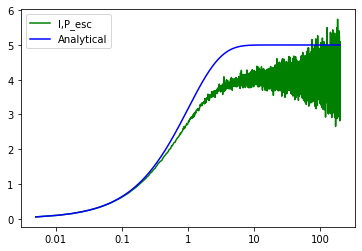

In [30]:
# Plots
plt.plot(np.log(a),I_values, color = 'g', label = 'I,P_esc')
plt.plot(np.log(a),I_analytic, color = 'b', label = 'Analytical')
plt.legend()
plt.xticks([-4,-2,0,2,4],[0.01,0.1,1,10,100])